In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
import os, sys

from phm08ds.models import experiment

## Load Dataset

In [2]:
folderpath = '../../data/interim/'
data_op_1 = pd.read_csv(folderpath + 'data_op_01.csv')
data_op_1.head()

,unit,time_step,operational_setting_1,operational_setting_2,operational_setting_3,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_11,Sensor_12,Sensor_15,Operational_condition,Health_state
2,1,3,34.9986,0.8401,60.0,1368.17,1122.49,5.48,2222.86,183.26,2387.95,0.02,1,1
11,1,12,35.0029,0.8413,60.0,1360.54,1130.69,5.48,2222.88,183.41,2387.95,0.02,1,1
23,1,24,34.9987,0.8400,60.0,1359.28,1131.95,5.48,2222.88,183.36,2387.94,0.02,1,2
38,1,39,35.0010,0.8400,60.0,1370.11,1126.43,5.48,2222.88,183.45,2387.95,0.02,1,2
40,1,41,35.0018,0.8400,60.0,1359.77,1129.48,5.48,2222.89,182.97,2387.98,0.02,1,2


## Data preprocessing

### Get rid of informations there are not sensor readings

Wang (2008) reports Sensor 15 has importat information. However, there are no relevant informations of this sensor. The data seems to be corrupted like this:

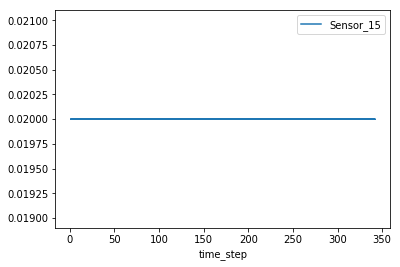

In [3]:
data_op_1.plot(x='time_step', y='Sensor_15')

Let's remove it from our database creating an object transformer.

In [4]:
from phm08ds.features.feature_selection import RemoveSensor

tf_remove_sensor_15 = RemoveSensor(sensors=[15])
data_op_1 = tf_remove_sensor_15.fit_transform(data_op_1)
data_op_1.head()

,unit,time_step,operational_setting_1,operational_setting_2,operational_setting_3,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_11,Sensor_12,Operational_condition,Health_state
2,1,3,34.9986,0.8401,60.0,1368.17,1122.49,5.48,2222.86,183.26,2387.95,1,1
11,1,12,35.0029,0.8413,60.0,1360.54,1130.69,5.48,2222.88,183.41,2387.95,1,1
23,1,24,34.9987,0.8400,60.0,1359.28,1131.95,5.48,2222.88,183.36,2387.94,1,2
38,1,39,35.0010,0.8400,60.0,1370.11,1126.43,5.48,2222.88,183.45,2387.95,1,2
40,1,41,35.0018,0.8400,60.0,1359.77,1129.48,5.48,2222.89,182.97,2387.98,1,2


Before feeding to the classifier, let's remove unwanted information, such as unit, time_step and operational settings.

In [5]:
from phm08ds.features.feature_selection import RemoveInfo

tf_remove_info = RemoveInfo()

data_with_features = tf_remove_info.fit_transform(data_op_1)
data_with_features.head()

,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_11,Sensor_12,Health_state
2,1368.17,1122.49,5.48,2222.86,183.26,2387.95,1
11,1360.54,1130.69,5.48,2222.88,183.41,2387.95,1
23,1359.28,1131.95,5.48,2222.88,183.36,2387.94,2
38,1370.11,1126.43,5.48,2222.88,183.45,2387.95,2
40,1359.77,1129.48,5.48,2222.89,182.97,2387.98,2


We need to normalize our data. Let's use Z-score standardization.

In [6]:
from sklearn.preprocessing import StandardScaler

tf_std_scaller = preprocessing.StandardScaler()
data_with_features_std = tf_std_scaller.fit_transform(data_with_features.drop(labels='Health_state', axis=1))
data_with_features_std

array([[ 2.18753538e-01, -1.28328598e+00, -1.00000000e+00,
        -5.61707703e-01,  6.68924330e-01, -5.45027910e-01],
       [-1.13058311e+00, -1.71913583e-01, -1.00000000e+00,
        -4.90969556e-01,  1.06520396e+00, -5.45027910e-01],
       [-1.35340934e+00, -1.14172757e-03, -1.00000000e+00,
        -4.90969556e-01,  9.33110750e-01, -5.78004106e-01],
       ...,
       [ 8.83695318e-01,  9.06930839e-01, -1.00000000e+00,
        -1.12761287e+00, -1.10112469e+00, -1.40240900e+00],
       [ 1.05523615e+00,  9.55722798e-01, -1.00000000e+00,
        -1.26908916e+00, -1.60307888e+00, -1.13859943e+00],
       [ 2.31968661e+00,  1.83397806e+00, -1.00000000e+00,
        -1.69351804e+00, -2.58056864e+00, -1.83109955e+00]])

In [7]:
labels_op_1 = np.array(data_with_features['Health_state'])
labels_op_1

array([1, 1, 2, ..., 4, 4, 4])

# Classification steps

## Load Experiment model

In [8]:
from phm08ds.models import experiment

## Define classifiers and its specifications

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

/home/navar/anaconda3/envs/phm08ds/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [10]:
knn_clf = KNeighborsClassifier()
random_forest_clf = RandomForestClassifier()
naive_bayes_clf = GaussianNB()
gaussian_linear_clf = LinearDiscriminantAnalysis()
gaussian_quadratic_clf = QuadraticDiscriminantAnalysis()
perceptron_clf = Perceptron()
sgd_clf = SGDClassifier()

## Put all clf in a dictionary:

In [11]:
classifiers = {'KNN': knn_clf, 'RF': random_forest_clf, 'Naive_bayes': naive_bayes_clf,
               'Gaussian_linear': gaussian_linear_clf, 'Gaussian_quadratic': gaussian_quadratic_clf,
               'Perceptron': perceptron_clf, 'SGDClassifier': sgd_clf}

## Train Classifiers and test them

Stratified cross-validation for model selection are going to be used.

In [12]:
kfolds = 10
clf_outputs = experiment.run_classifiers(data_with_features_std, labels_op_1, classifiers, kfolds)

/home/navar/anaconda3/envs/phm08ds/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/navar/anaconda3/envs/phm08ds/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/navar/anaconda3/envs/phm08ds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/navar/anaconda3/envs/phm08ds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol 

## Performance assessment

Saving variables in a dictionary:

In [13]:
results = {}
results['train'] = experiment.results_clf(4, clf_outputs['train']['true'], clf_outputs['train']['pred'])
results['test'] = experiment.results_clf(4, clf_outputs['test']['true'], clf_outputs['test']['pred'])

/home/navar/anaconda3/envs/phm08ds/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/navar/anaconda3/envs/phm08ds/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Savel results, models and pipeline to a .pkl file 

In [14]:
from sklearn.pipeline import Pipeline

data_preprocessing = Pipeline([('remove_sensor_15', tf_remove_sensor_15),
                               ('remove_info', tf_remove_info),
                               ('std_scaler', tf_std_scaller)
                              ])

In [15]:
experiment.save_models(classifiers)
experiment.save_pipeline(data_preprocessing)

## Save results to CSVs and figures

In [16]:
experiment.export_results(results['test'], 'test')
experiment.export_results(results['train'], 'train')

/mnt/Work/Mestrado/Mestrado/MP-Safety_ITA/Analyses_and_Experiments/PHM08_data_science/notebooks/model_selection-OP_01-navarmn
KNN
RF
Naive_bayes
Gaussian_linear
Gaussian_quadratic
Perceptron
SGDClassifier
/mnt/Work/Mestrado/Mestrado/MP-Safety_ITA/Analyses_and_Experiments/PHM08_data_science/notebooks/model_selection-OP_01-navarmn
KNN
RF
Naive_bayes
Gaussian_linear
Gaussian_quadratic
Perceptron
SGDClassifier
